<a href="https://colab.research.google.com/github/SMN-SENAMHI/MONITOREO/blob/main/ERA5_SURFACE_MONTH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
!pip install -q xarray zarr fsspec==2025.3.0 numcodecs requests==2.32.4 aiohttp > /dev/null 2>&1
!apt-get install -qq -y libproj-dev proj-data proj-bin libgeos-dev > /dev/null 2>&1
!pip install -q cartopy shapely pyproj > /dev/null 2>&1



In [33]:
#@title Importar librerías
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import requests, os, warnings
#import warnings
from cartopy.io import DownloadWarning
warnings.filterwarnings("ignore", category=DownloadWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [34]:
# ==============================================
# Guardar token en Colab (.netrc)
# ==============================================

#Reemplaza con tu token segun usuario registrado
#TOKEN = "edh_pat_cfdba8b50c493e84dfc676f5f1efed1794dde11c40cd21237e54c21da72c2f9378c792defeb8e2ca4638ac478df26ab8"
TOKEN = "edh_pat_fcb2e9f52c35ff7fd7cc2f2d14317393c9e299c8c1c1f81a94216161433a0943f554036a62b849c1af67f0c0400c31e3"

# Crear el archivo
with open("/root/.netrc", "w") as f:
    f.write("machine data.earthdatahub.destine.eu\n")
    f.write(f"  password {TOKEN}\n")

# Permisos
!chmod 600 /root/.netrc


In [35]:
# -----------------------------
# Abrir dataset ERA5
# -----------------------------
url = "https://data.earthdatahub.destine.eu/era5/reanalysis-era5-single-levels-monthly-means-v0.zarr"

ds = xr.open_dataset(
    url,
    engine="zarr",
    chunks="auto",
    storage_options={"client_kwargs": {"trust_env": True}}
)

# -----------------------------
#Lista Variables
# -----------------------------
variables = []
for var in ds.data_vars:
    units = ds[var].attrs.get("units", "sin unidades")
    long_name = ds[var].attrs.get("long_name", "sin descripción")
    variables.append([var, units, long_name])

df = pd.DataFrame(variables, columns=["Variable", "Unidades", "Descripción"])
print("Variables disponibles en ERA5:\n")
print(df.to_string(index=False))

# -----------------------------
#Rango temporal del dataset
# -----------------------------
fechas = pd.to_datetime(ds.valid_time.values)
inicio = fechas.min().strftime("%Y-%m")
fin    = fechas.max().strftime("%Y-%m")

print("\n Rango temporal del dataset ERA5:")
print(f"Inicio: {inicio}")
print(f"Fin:    {fin}")
print(f"Total de meses: {len(fechas)}")



Variables disponibles en ERA5:

Variable Unidades                  Descripción
     d2m        K 2 metre dewpoint temperature
     msl       Pa      Mean sea level pressure
      sp       Pa             Surface pressure
     sst        K      Sea surface temperature
     t2m        K          2 metre temperature
      tp        m          Total precipitation
     u10  m s**-1    10 metre U wind component
     v10  m s**-1    10 metre V wind component

 Rango temporal del dataset ERA5:
Inicio: 1940-01
Fin:    2025-08
Total de meses: 1028


In [70]:
# ============================================
# 2. Selección de parámetros (fecha y país)
# ============================================
#@title Selección de parámetros
fecha_analisis = "2025-08"   #@param ["2025-01","2025-02","2025-03","2025-04","2025-05","2025-06","2025-07","2025-08","2025-09","2025-10","2025-11","2025-12"]
Pais_seleccion = "Argentina" #@param ["Argentina","Bolivia","Brasil","Chile","Colombia","Costa Rica","Ecuador","French Guiana","Guyana","Panamá","Paraguay","Perú","Suriname","Uruguay","Venezuela"]

anio, mes = fecha_analisis.split("-")
mes = int(mes)

print(f"Fecha seleccionada: {fecha_analisis}")
print(f"País seleccionado: {Pais_seleccion}")



Fecha seleccionada: 2025-08
País seleccionado: Argentina


In [71]:
#@title Cargar shapefile Sudamérica
shapefiles = {
    "SUDAMERICA.shp": "https://raw.githubusercontent.com/SMN-SENAMHI/Materiales/main/shape/SUDAMERICA.shp",
    "SUDAMERICA.dbf": "https://raw.githubusercontent.com/SMN-SENAMHI/Materiales/main/shape/SUDAMERICA.dbf",
    "SUDAMERICA.shx": "https://raw.githubusercontent.com/SMN-SENAMHI/Materiales/main/shape/SUDAMERICA.shx",
}

def download_file(url, local_path):
    r = requests.get(url, stream=True)
    if r.status_code == 200:
        with open(local_path, "wb") as f:
            f.write(r.content)

for name, url in shapefiles.items():
    if not os.path.exists(name):
        download_file(url, name)

gdf = gpd.read_file("SUDAMERICA.shp").set_crs("EPSG:32718").to_crs("EPSG:4326")
gdf["NOMBRE"] = gdf["NOMBRE"].replace({"PerÃº": "Perú", "Panama": "Panamá"})

gdf_pais = gdf[gdf["NOMBRE"].str.upper() == Pais_seleccion.upper()]
if gdf_pais.empty:
    raise ValueError(f"No se encontró el país '{Pais_seleccion}' en el shapefile.")

minx, miny, maxx, maxy = gdf_pais.total_bounds
print("Bounds:", gdf_pais.total_bounds)



Bounds: [-73.58537629 -55.05478161 -53.65138475 -21.78396425]


In [72]:
#@title Abrir dataset ERA5
url = "https://data.earthdatahub.destine.eu/era5/reanalysis-era5-single-levels-monthly-means-v0.zarr"

ds = xr.open_dataset(
    url,
    engine="zarr",
    chunks={"time": 12},   # lectura por bloques (12 meses)
    storage_options={"client_kwargs": {"trust_env": True}}
)

print("Variables disponibles:", list(ds.data_vars))



Variables disponibles: ['d2m', 'msl', 'sp', 'sst', 't2m', 'tp', 'u10', 'v10']


In [73]:
#@title Seleccionar y recortar variables

# Precipitación total (m → mm/mes)
fechas = pd.to_datetime(ds.valid_time.values)
dias_mes = xr.DataArray(
    fechas.days_in_month,
    coords={"valid_time": ds.valid_time},
    dims=["valid_time"]
)

# Conversión: m/día → mm/mes
tp = ds["tp"] * 1000 * dias_mes
tp.attrs["units"] = "mm/mes"

# Temperatura 2m (K → °C)
t2m = ds["t2m"] - 273.15
t2m.attrs["units"] = "°C"

# Recortes usando shapefile
tp_sel  = tp.sel(latitude=slice(maxy, miny),
                 longitude=slice(minx % 360, maxx % 360))
t2m_sel = t2m.sel(latitude=slice(maxy, miny),
                  longitude=slice(minx % 360, maxx % 360))

# Selección de mes específico
tp_target  = tp_sel.sel(valid_time=fecha_analisis)
t2m_target = t2m_sel.sel(valid_time=fecha_analisis)

In [74]:
#@title Calcular climatologías y anomalías
# Precipitación
clim_tp_1990_2020 = tp_sel.sel(valid_time=slice("1990-01", "2020-12"))
clim_tp_1990_2020_mes = clim_tp_1990_2020.sel(valid_time=clim_tp_1990_2020["valid_time"].dt.month == mes)
clim_tp_1990_2020_mean = clim_tp_1990_2020_mes.mean("valid_time")

clim_tp_1981_2010 = tp_sel.sel(valid_time=slice("1981-01", "2010-12"))
clim_tp_1981_2010_mes = clim_tp_1981_2010.sel(valid_time=clim_tp_1981_2010["valid_time"].dt.month == mes)
clim_tp_1981_2010_mean = clim_tp_1981_2010_mes.mean("valid_time")

# Temperatura
clim_t2m_1990_2020 = t2m_sel.sel(valid_time=slice("1990-01", "2020-12"))
clim_t2m_1990_2020_mes = clim_t2m_1990_2020.sel(valid_time=clim_t2m_1990_2020["valid_time"].dt.month == mes)
clim_t2m_1990_2020_mean = clim_t2m_1990_2020_mes.mean("valid_time")

clim_t2m_1981_2010 = t2m_sel.sel(valid_time=slice("1981-01", "2010-12"))
clim_t2m_1981_2010_mes = clim_t2m_1981_2010.sel(valid_time=clim_t2m_1981_2010["valid_time"].dt.month == mes)
clim_t2m_1981_2010_mean = clim_t2m_1981_2010_mes.mean("valid_time")

# Anomalías
anom_tp_1990_2020  = tp_target  - clim_tp_1990_2020_mean
anom_tp_1981_2010  = tp_target  - clim_tp_1981_2010_mean
anom_t2m_1990_2020 = t2m_target - clim_t2m_1990_2020_mean
anom_t2m_1981_2010 = t2m_target - clim_t2m_1981_2010_mean


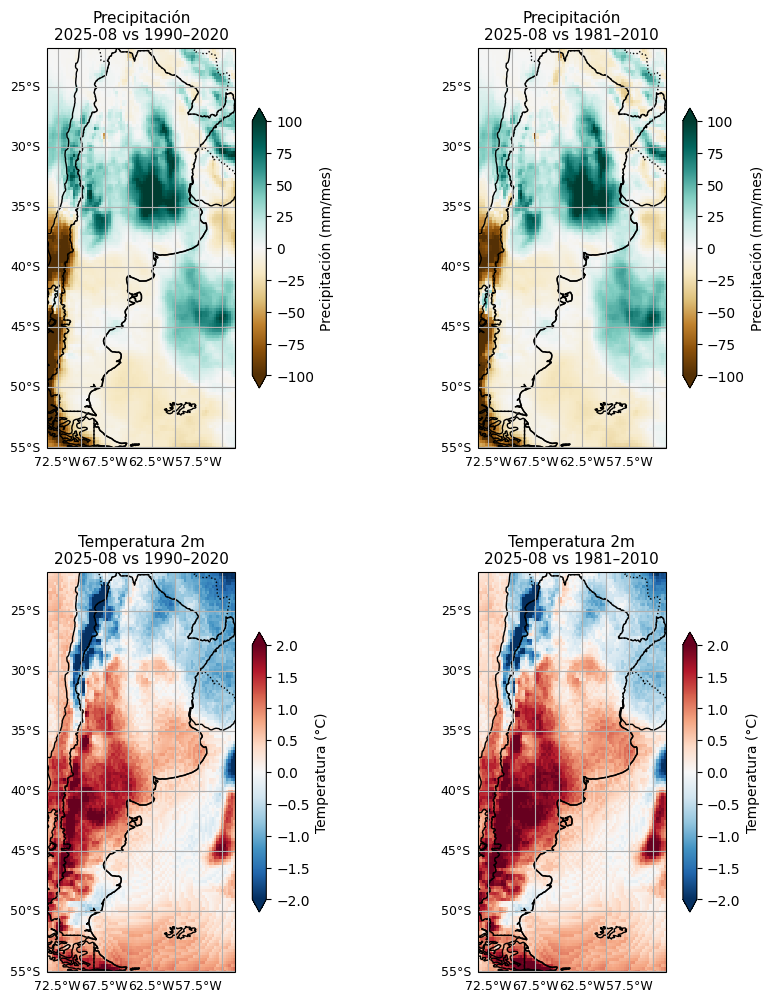

In [75]:
#@title Graficar anomalías de Precipitación y Temperatura
fig, axes = plt.subplots(2, 2, figsize=(10, 12),
                         subplot_kw={"projection": ccrs.PlateCarree()},
                         gridspec_kw={"wspace": 0.25, "hspace": 0.31})
for ax in axes.flat:
    ax.set_extent([minx, maxx, miny, maxy], crs=ccrs.PlateCarree())
    ax.coastlines(resolution="50m")
    ax.add_feature(cfeature.BORDERS, linestyle=":")
    ax.add_feature(cfeature.LAND, facecolor="lightgray", alpha=0.4)
    gdf_pais.boundary.plot(ax=ax, edgecolor="black", linewidth=1)

    # Etiquetas lat/lon
    gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LongitudeFormatter()
    gl.yformatter = LatitudeFormatter()
    gl.xlabel_style = {"size": 9}
    gl.ylabel_style = {"size": 9}

# Precipitación
anom_tp_1990_2020.plot(
    ax=axes[0,0], transform=ccrs.PlateCarree(),
    cmap="BrBG", vmin=-100, vmax=100,
    cbar_kwargs={"label": "Precipitación (mm/mes)", "shrink": 0.7}
)
axes[0,0].set_title(f"Precipitación\n{fecha_analisis} vs 1990–2020", fontsize=11, loc="center")

anom_tp_1981_2010.plot(
    ax=axes[0,1], transform=ccrs.PlateCarree(),
    cmap="BrBG", vmin=-100, vmax=100,
    cbar_kwargs={"label": "Precipitación (mm/mes)", "shrink": 0.7}
)
axes[0,1].set_title(f"Precipitación\n{fecha_analisis} vs 1981–2010", fontsize=11, loc="center")

# Temperatura
anom_t2m_1990_2020.plot(
    ax=axes[1,0], transform=ccrs.PlateCarree(),
    cmap="RdBu_r", vmin=-2, vmax=2,
    cbar_kwargs={"label": "Temperatura (°C)", "shrink": 0.7}
)
axes[1,0].set_title(f"Temperatura 2m\n{fecha_analisis} vs 1990–2020", fontsize=11, loc="center")

anom_t2m_1981_2010.plot(
    ax=axes[1,1], transform=ccrs.PlateCarree(),
    cmap="RdBu_r", vmin=-2, vmax=2,
    cbar_kwargs={"label": "Temperatura (°C)", "shrink": 0.7}
)
axes[1,1].set_title(f"Temperatura 2m\n{fecha_analisis} vs 1981–2010", fontsize=11, loc="center")

plt.show()


Usando coordenadas: lat=-12, lon=-78 (convertido a 282)


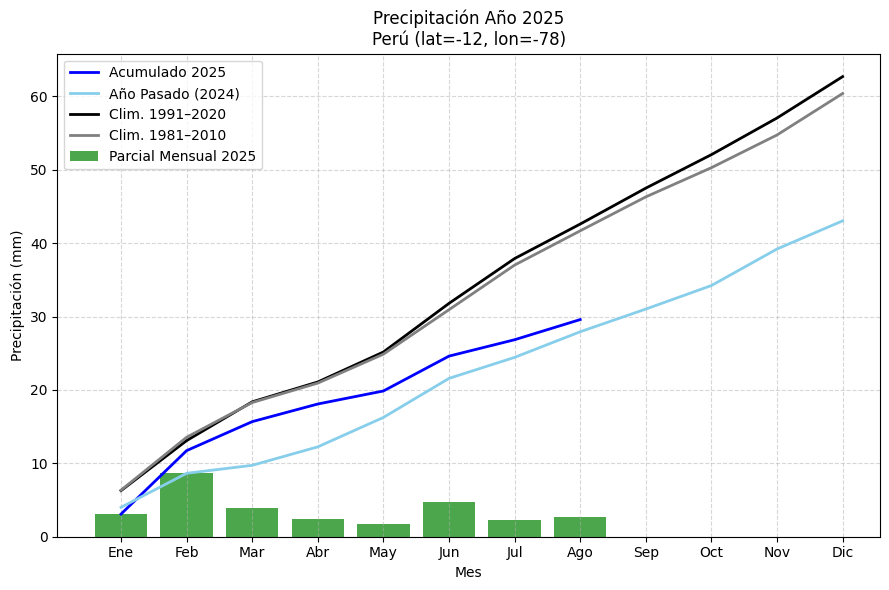

In [ ]:
# ============================================
# Gráfico de precipitación mensual acumulada en un punto
# ============================================
import numpy as np
from geopy.geocoders import Nominatim

lat_in, lon_in = -12, -78

if lon_in < 0:
    lon_punto = 360 + lon_in   # -80 → 280
else:
    lon_punto = lon_in
lat_punto = lat_in

print(f"Usando coordenadas: lat={lat_in}, lon={lon_in} (convertido a {lon_punto})")

try:
    geolocator = Nominatim(user_agent="geoapi")
    location = geolocator.reverse((lat_in, lon_in), language="es")
    address = location.raw.get("address", {})

    lugar = (
        address.get("city") or
        address.get("town") or
        address.get("village") or
        address.get("county") or
        address.get("state_district") or
        address.get("state")
    )
    pais = address.get("country")
    lugar_str = f"{lugar}, {pais}" if lugar else pais
except Exception as e:
    print("No se pudo identificar el lugar:", e)
    lugar_str = "Ubicación desconocida"

tp_punto = tp.sel(latitude=lat_punto, longitude=lon_punto, method="nearest")

df = tp_punto.to_dataframe().reset_index()
df["año"] = df["valid_time"].dt.year
df["mes"] = df["valid_time"].dt.month

anio_actual = 2025
anio_pasado = 2024

df_actual = df[df["año"] == anio_actual].groupby("mes")["tp"].mean()
df_pasado = df[df["año"] == anio_pasado].groupby("mes")["tp"].mean()

df_1981_2010 = df[(df["año"] >= 1981) & (df["año"] <= 2010)].groupby("mes")["tp"].mean()
df_1991_2020 = df[(df["año"] >= 1991) & (df["año"] <= 2020)].groupby("mes")["tp"].mean()

acum_actual = df_actual.cumsum()
acum_pasado = df_pasado.cumsum()
acum_1981_2010 = df_1981_2010.cumsum()
acum_1991_2020 = df_1991_2020.cumsum()

fig, ax = plt.subplots(figsize=(9,6))

ax.bar(df_actual.index, df_actual.values, color="green", alpha=0.7, label="Parcial Mensual 2025")

ax.plot(acum_actual.index, acum_actual.values, color="blue", linewidth=2, label="Acumulado 2025")
ax.plot(acum_pasado.index, acum_pasado.values, color="skyblue", linewidth=2, label="Año Pasado (2024)")
ax.plot(acum_1991_2020.index, acum_1991_2020.values, color="black", linewidth=2, label="Clim. 1991–2020")
ax.plot(acum_1981_2010.index, acum_1981_2010.values, color="gray", linewidth=2, label="Clim. 1981–2010")

ax.set_title(f"Precipitación Año {anio_actual}\n{lugar_str} (lat={lat_in}, lon={lon_in})")
ax.set_xlabel("Mes")
ax.set_ylabel("Precipitación (mm)")
ax.set_xticks(range(1,13))
ax.set_xticklabels(["Ene","Feb","Mar","Abr","May","Jun","Jul","Ago","Sep","Oct","Nov","Dic"])
ax.legend()
ax.grid(True, linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()
